In [37]:
import json
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from model import n_node_increase_scores, plot_fitting_graph, _model

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 8]
matplotlib.rcParams.update({
    'font.size': 15,
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "axes.facecolor": "white",
    "axes.edgecolor": "darkgrey",
    "axes.labelcolor": "darkgrey",
})

In [38]:
df = pd.read_csv('data/prepped/spotify_featured.csv')
ycolumn = 'target'
xcolumns = [c for c in df.columns if c != ycolumn]
seed = 99
test_size = 0.2

In [39]:
with open(f'data/output/model_outputs_20210308071110.json', 'r') as stream:
    model_comparison = json.load(stream)
outputdf = pd.read_csv('data/output/model_outputs_20210308071110.csv')

In [40]:
modelrows = []
for m in model_comparison.keys():
    for n in range(len(xcolumns)):
        modelrows.append(m)
outputdf['model'] = modelrows
outputdf[['n_features', 'score', 'model']].to_csv('data/output/model_outputs_20210308071110.csv', index=False, quoting=csv.QUOTE_NONNUMERIC, quotechar='"')

## 1. Model comparisons

## 1.1 n features vs accuracy

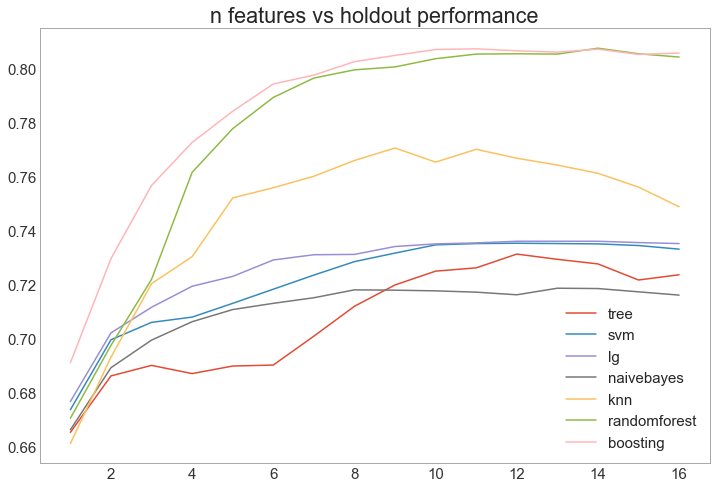

In [41]:
count = 0
for m in model_comparison.keys():
    pltdf = outputdf.loc[lambda x: x['model']==m]
    pltdf.index = pltdf['n_features']
    plt.plot(pltdf['score'])
    count += 1
plt.title('n features vs holdout performance')
plt.legend(model_comparison.keys())
plt.show()

## 1.1 AUC and other score comparisons

In [42]:
def precision(y_test, y_predict):
    """Correcly predicted instances over the true predictions: tp / (tp + fp)"""
    return len([t for t, p in zip(y_test, y_predict) if t == p and p == 1]) / len([_p for _p in y_predict if _p == 1])

def recall(y_test, y_predict):
    """Correcly predicted instances over the true instances, True positive rate: tp / (tp + fn)"""
    return len([t for t, p in zip(y_test, y_predict) if t == p and t == 1]) / len([_t for _t in y_test if _t == 1])

def f_measure(y_test, y_predict):
    """Measure to balance fp & fn"""
    prec = precision(y_test, y_predict)
    rec = recall(y_test, y_predict)
    return 2 * (prec * rec) / (prec + rec)

count = 0
result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc', 'precision', 'recall', 'fmeasure', 'accuracy'])
for m in ['tree', 'naivebayes', 'knn', 'lg', 'randomforest', 'boosting']:

    X = df[model_comparison[m]['features']].values
    y = df[ycolumn].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    classifier = _model(X_train, X_test, y_train, y_test, method=m, seed=seed, return_model=True)
    y_predict = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[::, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    prec = precision(y_test, y_predict)
    rec = recall(y_test, y_predict)
    fm = f_measure(y_test, y_predict)
    acc = metrics.accuracy_score(y_test, y_predict)
    
    result_table = result_table.append({'classifiers': classifier.__class__.__name__,
                                        'fpr': fpr, 
                                        'tpr': tpr, 
                                        'auc': auc,
                                        'precision': prec,
                                        'recall': rec,
                                        'fmeasure': fm,
                                        'accuracy': acc
                                       }, ignore_index=True)
    
    count += 1
    if count == 10:
        break

In [43]:
result_table[['classifiers', 'auc', 'precision', 'recall', 'fmeasure', 'accuracy']].to_csv('data/output/model_metrics_20210308071110.csv', index=False)

In [44]:
result_table[['classifiers', 'auc', 'precision', 'recall', 'fmeasure', 'accuracy']]

,classifiers,auc,precision,recall,fmeasure,accuracy
0,DecisionTreeClassifier,0.731706,0.740750,0.724245,0.732405,0.731331
1,GaussianNB,0.795599,0.668294,0.885242,0.761620,0.718682
2,KNeighborsClassifier,0.837872,0.762145,0.796838,0.779105,0.770615
3,LogisticRegression,0.804089,0.708750,0.815046,0.758190,0.736074
4,RandomForestClassifier,0.881763,0.783465,0.858170,0.819117,0.807589
5,GradientBoostingClassifier,0.881654,0.775415,0.873503,0.821541,0.807346


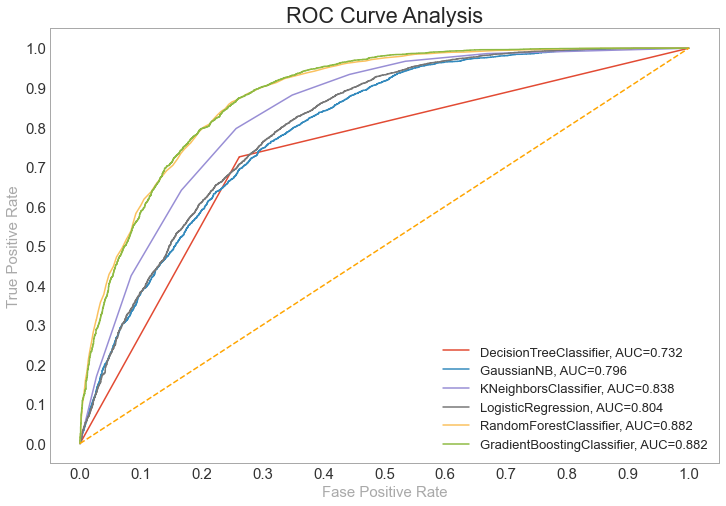

In [45]:
fig = plt.figure(figsize=(12, 8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifiers'], result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Fase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis')
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## 2 fitting graph plot for tree modeling

In [46]:
start_depth = 1
end_depth = 20
model_to_run = 'randomforest'

In [47]:
print('Selected features:')
for x in model_comparison[model_to_run]['features']:
    print(f'-- {x}')

Selected features:
-- instrumentalness
-- n_artist_tracks
-- acousticness
-- duration_ms
-- danceability
-- valence
-- speechiness
-- loudness
-- energy
-- tempo
-- key
-- mode
-- liveness
-- time_signature


In [48]:
# xcolumns = [c for c in df.columns if c != ycolumn]
# X = df[xcolumns].values
X = df[model_comparison[model_to_run]['features']].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = n_node_increase_scores(X_train, y_train, X_test, y_test, range(start_depth, end_depth+1), model_to_run, seed)

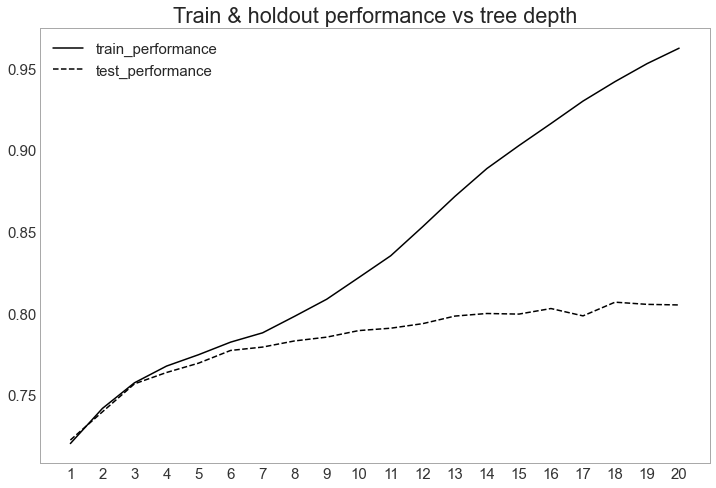

In [49]:
plot_fitting_graph(scores)

## 2. tree model -> random forest

## 2.1 model accuracy + tree plot

In [50]:
model_to_run = 'randomforest'
selected_features = model_comparison[model_to_run]['features'][:7]
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
if model_to_run == 'tree':
    classifier = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=seed)
elif model_to_run == 'randomforest':
    classifier = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
y_probas = classifier.predict_proba(X_test)[:, 1]
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [51]:
print(f'Accuracy score of {model_to_run} model {round(score, 3)*100}%')

Accuracy score of randomforest model 76.3%


<module 'sklearn.tree' from '/Users/simonvreugdenhil/dev/uva-strategy-analytics/venv/lib/python3.8/site-packages/sklearn/tree/__init__.py'>

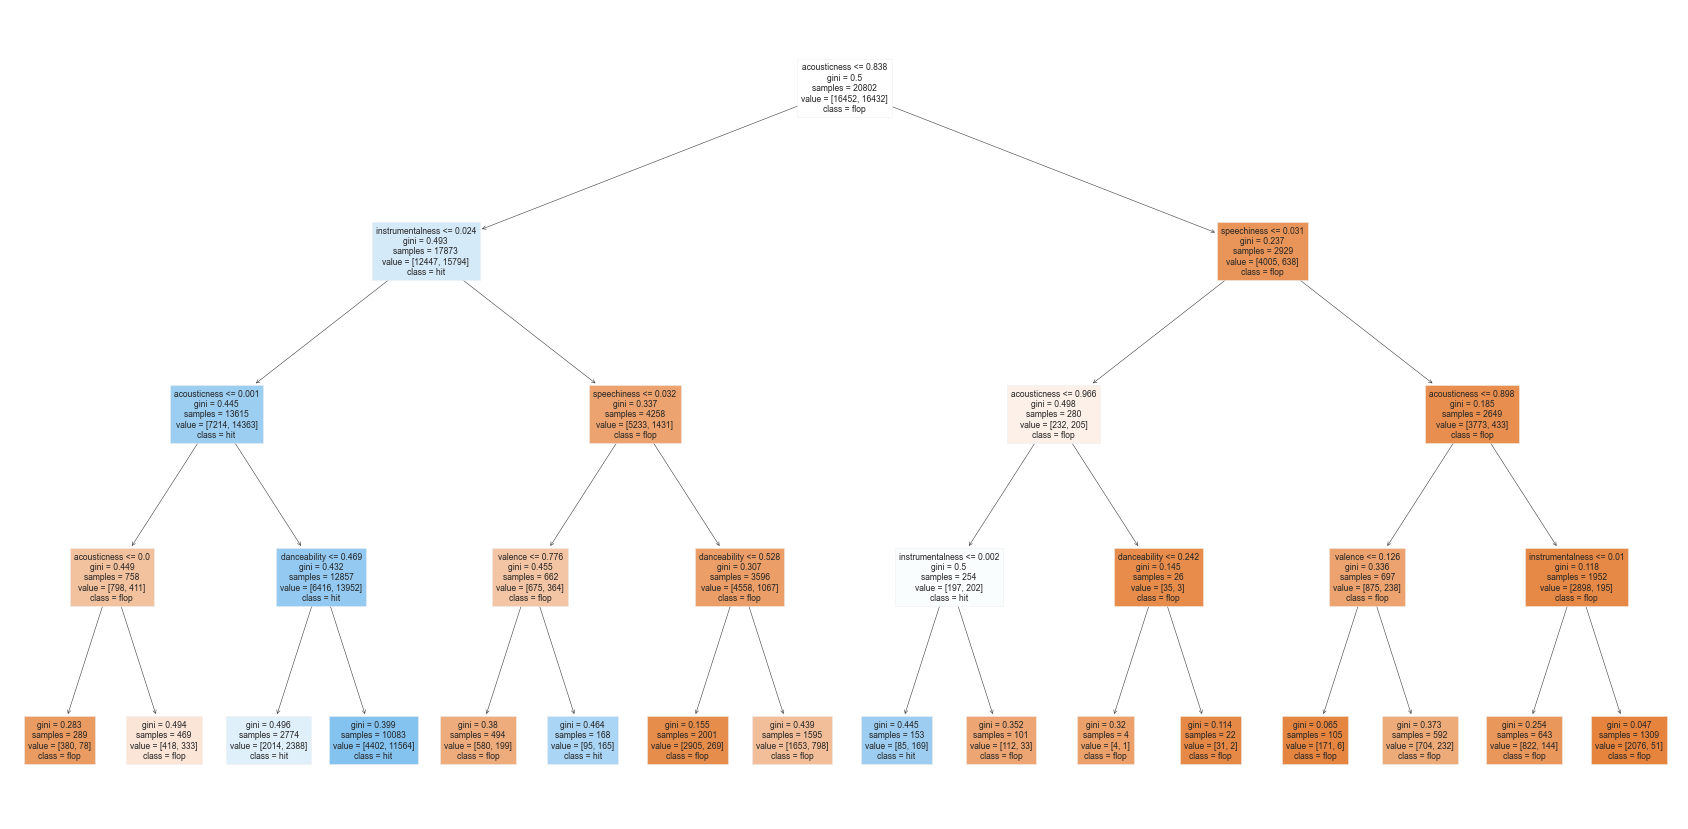

In [52]:
plt.figure(figsize=(30,15))
if model_to_run == 'tree':
    tree.plot_tree(classifier,
                   feature_names=selected_features,
                   class_names=['hit', 'flop'],
                   filled=True,
                   fontsize=8.5)
elif model_to_run == 'randomforest':
    tree.plot_tree(classifier.estimators_[0],
                   feature_names=selected_features,
                   class_names=['flop', 'hit'],
                   filled=True,
                   fontsize=8.5)
tree

## 2.2 Tree confusion matrix

In [53]:
dfconfusion = pd.DataFrame({
    'y_predict': y_predict,
    'y_test': y_test,
             })
dfconfusion['count'] = 1
dfx = dfconfusion.groupby(['y_predict', 'y_test'], as_index=False)[['count']].sum()
for z in [0, 1]:
    dfx.loc[lambda x: x['y_test']==z, 'percent'] = round(dfx.loc[lambda x: x['y_test']==z]['count'] / dfx.loc[lambda x: x['y_test']==z]['count'].sum(), 3)
dfx

,y_predict,y_test,count,percent
0,0,0,2639,0.652
1,0,1,537,0.129
2,1,0,1409,0.348
3,1,1,3637,0.871


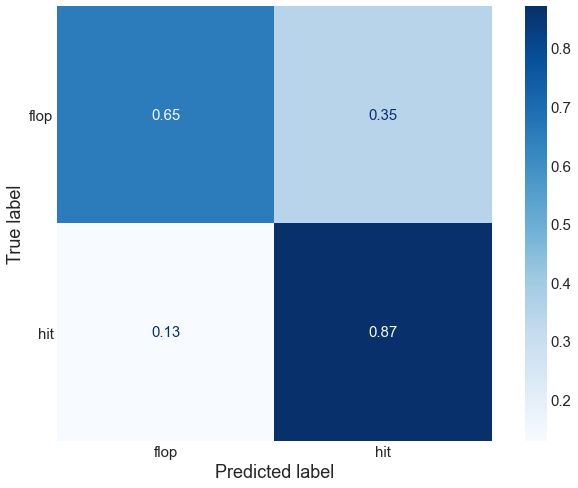

In [54]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use("seaborn-dark")

pltconf = plot_confusion_matrix(classifier,
                                X_test,
                                y_test,
                                display_labels=['flop', 'hit'],
                                cmap=plt.cm.Blues,
                                normalize='true'
                               )
pltconf

## 2.2 Tree plot

## 3. Linear model output -> feature importance

In [55]:
model_to_run = 'svm'
selected_features = model_comparison['randomforest']['features']
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classifier = LinearSVC(max_iter=100000, dual=True, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [56]:
print(f'Accuracy score of {model_to_run} model {round(score, 3)*100}%')

Accuracy score of svm model 73.2%


<ipython-input-57-101eb93a3f7f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(selected_features)


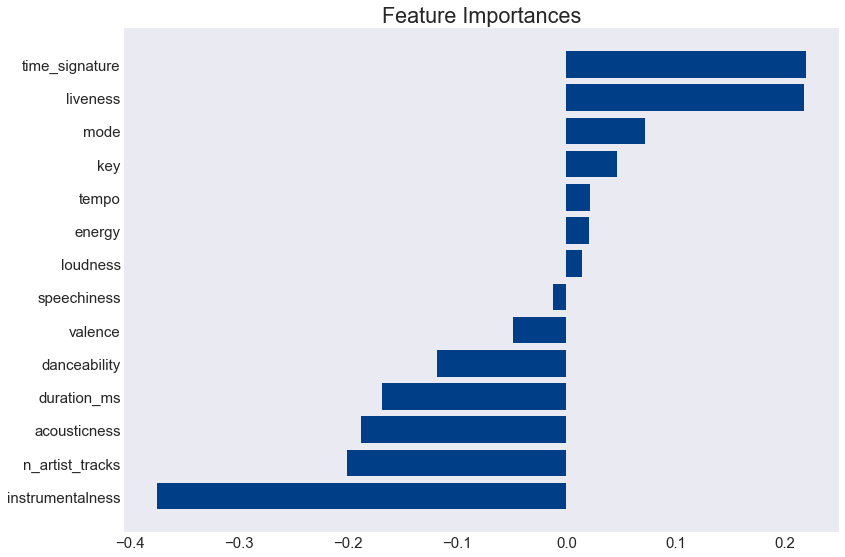

In [57]:
y_ticks = np.arange(0, len(selected_features))
fig, ax = plt.subplots()
ax.barh(y_ticks, sorted(list(classifier.coef_[0]), reverse=False), color='#003F87')
ax.set_yticklabels(selected_features)
ax.set_yticks(y_ticks)
ax.set_title("Feature Importances")
fig.tight_layout()
plt.show()

## 4. All models - accuracy + best performing features

In [58]:
for k, v in model_comparison.items():
    print(f'{k}:')
    print(f"- score {v['score']}")
    print(f"- n features {v['n_features']}")
    print('- features:')
    count = 1
    for x in v['features']:
        print(f'==> {count}: {x}')
        count += 1
    print('')

tree:
- score 0.7313306
- n features 12
- features:
==> 1: instrumentalness
==> 2: n_artist_tracks
==> 3: time_signature
==> 4: mode
==> 5: sections
==> 6: danceability
==> 7: speechiness
==> 8: acousticness
==> 9: duration_ms
==> 10: energy
==> 11: valence
==> 12: loudness

svm:
- score 0.7353442
- n features 12
- features:
==> 1: instrumentalness
==> 2: acousticness
==> 3: duration_ms
==> 4: mode
==> 5: n_artist_tracks
==> 6: speechiness
==> 7: danceability
==> 8: loudness
==> 9: energy
==> 10: valence
==> 11: liveness
==> 12: sections

lg:
- score 0.7360739
- n features 12
- features:
==> 1: instrumentalness
==> 2: danceability
==> 3: n_artist_tracks
==> 4: speechiness
==> 5: mode
==> 6: loudness
==> 7: energy
==> 8: valence
==> 9: acousticness
==> 10: key
==> 11: duration_ms
==> 12: chorus_hit

naivebayes:
- score 0.7186816
- n features 13
- features:
==> 1: instrumentalness
==> 2: energy
==> 3: danceability
==> 4: acousticness
==> 5: sections
==> 6: liveness
==> 7: valence
==> 8: 